In [1]:
import sys
import os
import numpy as np
import koi
os.chdir("..")
from torch.nn import CTCLoss
from tqdm import tqdm
# from koi.decode import beam_search
from torch.cuda import get_device_capability
import matplotlib.pyplot as plt

In [2]:
from models.decode_utils import *
from models.model import *
from dataloader import load_numpy_data, ctc_dataset

/home/zyserver/miniconda3/envs/Torch2.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zyserver/miniconda3/envs/Torch2.0/lib/python3.10/site-packages/flash_attn/ops/triton/layer_norm.py:985: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/home/zyserver/miniconda3/envs/Torch2.0/lib/python3.10/site-packages/flash_attn/ops/triton/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout, *args):


In [3]:
model = CTC_encoder(n_hid=512)
model.load_state_dict(torch.load("/data1/YHC/Model_Save/CTC_epoch:20_loss:0.235789_model_.pt"))
model = model.cuda()
model.eval()

/tmp/ipykernel_2771984/3907606209.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/data1/YHC/Model_Save/CTC_epoch:20_loss:0.235789_mode

CTC_encoder(
  (encoder): Sequential(
    (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv1d(8, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): Conv1d(64, 512, kernel_size=(15,), stride=(5,), padding=(7,))
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU()
    (12): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): SiLU()
    (15): Permute()
    (16): ReverseLSTM(
      (lstm): LSTM(512, 512)
    )
    

In [4]:
train_data, valid_data = load_numpy_data("/data1/YHC/QiTanTrain/QiTan_basecall_train_mini_v2", 0.97)
train_data_set = ctc_dataset(train_data)
valid_data_set = ctc_dataset(valid_data)

In [6]:
valid_loader = torch.utils.data.DataLoader( valid_data_set,
                                            batch_size=32,
                                            shuffle=False,
                                            num_workers=2,
                                            pin_memory=True)

In [26]:
base_dict = {1: [], 2: [], 3: [], 4: []}
input_dict = {1: [], 2: [], 3: [], 4: []}
with torch.inference_mode():
    for _, (datas, targets, target_lengths) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        datas, targets, target_lengths = datas.cuda(), targets.cuda(), target_lengths.cuda()
        inputs = model(datas)
        input_lengths = torch.full(size=(inputs.shape[1],),
                                    fill_value=inputs.shape[0],
                                    dtype=torch.long).cuda()
        seqs_, traces, quals = viterbi_decode(inputs.cpu())
        normed_sig = datas.cpu().numpy()
        for i in range(normed_sig.shape[0]):
            seq = seqs_[i]
            trace = np.argwhere(traces[i] == 1).flatten()
            qual = quals[i]
            sig = normed_sig[i].flatten()
            for idx in trace:
                if qual[idx] >= 53 : 
                    input_dict[seq[idx]].append(inputs[idx,i,:].cpu().numpy())
                    base_dict[seq[idx]].append(sig[(idx - 1) * 5 : (idx + 2) * 5])
                if qual[idx] < 50: continue
                

100%|██████████| 251/251 [01:22<00:00,  3.06it/s]


In [27]:
for arr in base_dict[1]:
    if (len(arr) != 15) :
        print(arr)

In [28]:
for key in base_dict.keys():
    base_dict[key] = np.array(base_dict[key])
for key in input_dict.keys():
    input_dict[key] = np.array(input_dict[key])

In [29]:
for key in base_dict.keys():
    print(base_dict[key].shape)
for key in input_dict.keys():
    print(input_dict[key].shape)

(467764, 15)
(235711, 15)
(223394, 15)
(370937, 15)
(467764, 5)
(235711, 5)
(223394, 5)
(370937, 5)


In [30]:
np.random.seed(0)
trim = 1000
for key in base_dict.keys():
    np.random.shuffle(base_dict[key])
    base_dict[key] = base_dict[key][:trim]
for key in input_dict.keys():
    np.random.shuffle(input_dict[key])
    input_dict[key] = input_dict[key][:trim]


# 降维

In [31]:
for key in base_dict.keys():
    print(base_dict[key].shape)
for key in input_dict.keys():
    print(input_dict[key].shape)


(1000, 15)
(1000, 15)
(1000, 15)
(1000, 15)
(1000, 5)
(1000, 5)
(1000, 5)
(1000, 5)


In [32]:
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

In [42]:
X = np.concatenate([base_dict[1][:100], base_dict[2][:100], base_dict[3][:100], base_dict[4][:100]], axis=0)
Y = np.zeros(400)
Y[:100] = 0
Y[100:200] = 1
Y[200:300] = 2
Y[300:] = 3

In [43]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

/home/zyserver/miniconda3/envs/Torch2.0/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


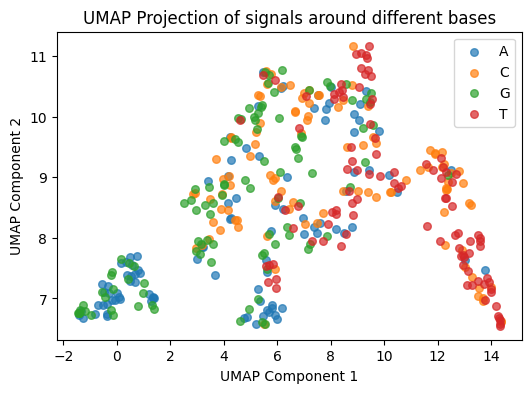

In [58]:
plt.figure(figsize=(6, 4))
labels = ['A', 'C', 'G', 'T']
for i in range(4):
    plt.scatter(x=X_umap[i*100:(i+1)*100,0], y=X_umap[i*100:(i+1)*100,1], label=labels[i], alpha=0.7, s= 30)
plt.title("UMAP Projection of signals around different bases")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend()
plt.savefig("fig1-E", dpi=400, bbox_inches="tight")
plt.show()

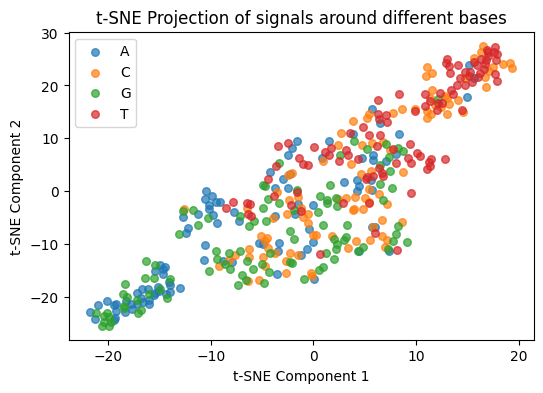

In [61]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 使用 t-SNE 对数据进行降维
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=3)
X_tsne = tsne.fit_transform(X)  # 假设 `data` 是原始高维数据

# 绘图
plt.figure(figsize=(6, 4))
labels = ['A', 'C', 'G', 'T']
for i in range(4):
    plt.scatter(x=X_tsne[i*100:(i+1)*100, 0], y=X_tsne[i*100:(i+1)*100, 1], 
                label=labels[i], alpha=0.7, s=30)
plt.title("t-SNE Projection of signals around different bases")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.savefig("fig1-E-tsne", dpi=400, bbox_inches="tight")
plt.show()


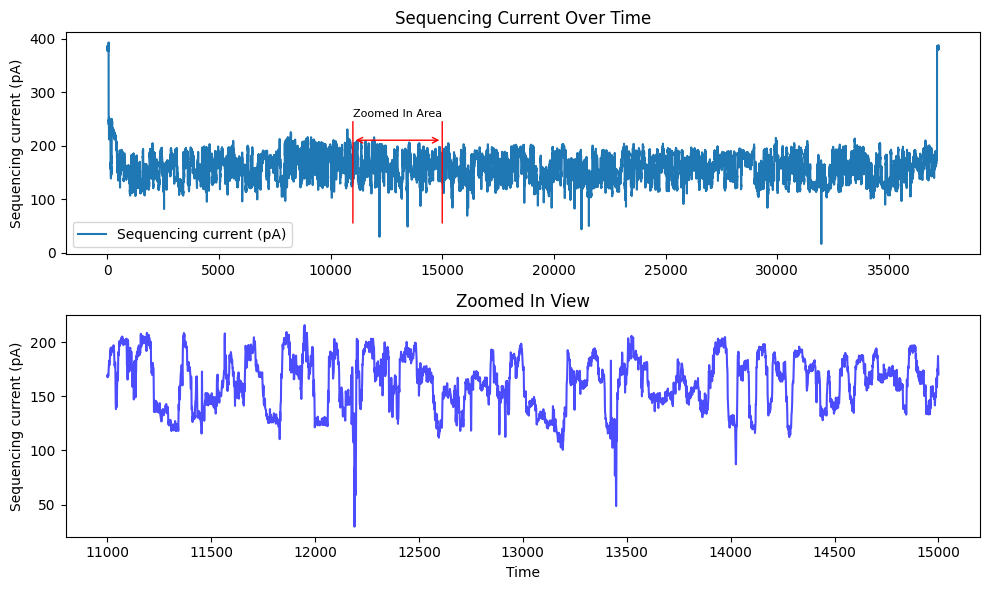

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch
import h5py
# 生成模拟数据
h5 = h5py.File("/data1/YHC/QiTan_data/Fruitfly/YF6419_h5/reads_0062_370520B6-495E-40A9-A054-129AD9FDF16B.h5", 'r')

for read_id in list(h5['Raw_data'].keys()):
    signal = h5['Raw_data'][read_id][()]
# time = np.linspace(0, 10, 1000)
# current = np.sin(time) + np.random.normal(0, 0.2, time.shape)
time = np.arange(len(signal))
current = signal


# 创建图形和子图
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# 绘制主图
axs[0].plot(time, current, label='Sequencing current (pA)')
axs[0].set_ylabel('Sequencing current (pA)')
axs[0].set_title('Sequencing Current Over Time')
axs[0].legend()

# 绘制放大图
zoom_start = 11000
zoom_end = 15000
zoom_time = time[(time >= zoom_start) & (time <= zoom_end)]
zoom_current = current[(time >= zoom_start) & (time <= zoom_end)]

axs[0].annotate('', xy=(zoom_start, 210), xytext=(zoom_end, 210),
                arrowprops=dict(arrowstyle='<->', color='red'))

axs[0].annotate('', xy=(zoom_start, 50), xytext=(zoom_start, 250),
                arrowprops=dict(arrowstyle='-', color='red'))
axs[0].annotate('', xy=(zoom_end, 50), xytext=(zoom_end, 250),
                arrowprops=dict(arrowstyle='-', color='red'))
axs[0].text((zoom_start + zoom_end) / 2, 250, 'Zoomed In Area',
            ha='center', va='bottom', color='black', fontsize=8,
            # bbox=dict(boxstyle="round", fc="white", ec="black")
            )

# 绘制放大图
zoom_time = time[(time >= zoom_start) & (time <= zoom_end)]
zoom_current = current[(time >= zoom_start) & (time <= zoom_end)]

axs[1].plot(zoom_time, zoom_current, label='Sequencing current (pA)', color='blue', alpha=0.7)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Sequencing current (pA)')
axs[1].set_title('Zoomed In View')

plt.tight_layout()
plt.savefig("fig1_C", dpi=400, bbox_inches="tight")
plt.show()

In [50]:
dict_std = {
    1 : np.std(base_dict[1], axis=0),
    2 : np.std(base_dict[2], axis=0),
    3 : np.std(base_dict[3], axis=0),
    4 : np.std(base_dict[4], axis=0),
}
dict_mean = {
    1 : np.mean(base_dict[1], axis=0), 
    2 : np.mean(base_dict[2], axis=0), 
    3 : np.mean(base_dict[3], axis=0), 
    4 : np.mean(base_dict[4], axis=0),
}

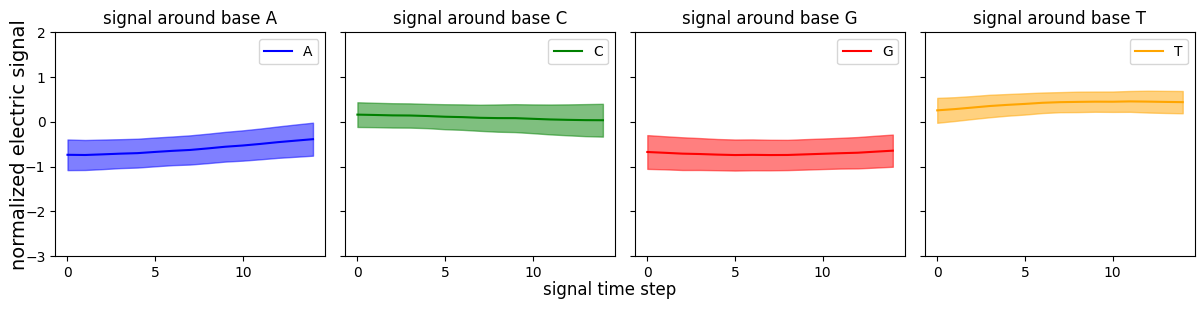

In [175]:
idxs = np.array([np.arange(15)] * 500, dtype=np.int16)

fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)

base_list = ["A", "C", "G", "T"]
color_list = ['blue', 'green', 'red', 'orange']

for i in range(4):

    axes[i].plot(dict_mean[i + 1], label=base_list[i], c=color_list[i])
    axes[i].fill_between(list(range(15)), dict_mean[i + 1] - dict_std[i + 1] / 2, dict_mean[i + 1] + dict_std[i + 1] / 2, color=color_list[i], alpha=0.5)
    # axes[i].scatter(idxs, base_dict[i + 1][:len(idxs)], s=2, color=color_list[i], alpha=0.3)
    # for j in range(100):
    #     axes[i].plot(base_dict[i + 1][j], c=color_list[i], alpha=0.1)
    axes[i].set_ylim([-3, 2])
    axes[i].set_title("signal around base {}".format(base_list[i]))
    axes[i].legend(loc='upper right')

fig.text(0.5, 0, 'signal time step', ha='center', fontsize=12)  # X轴标签
fig.text(0.0, 0.5, 'normalized electric signal', va='center', rotation='vertical', fontsize=14)  # Y轴标签

plt.tight_layout()
plt.savefig("fig1_1", dpi=400, bbox_inches="tight")
plt.show()

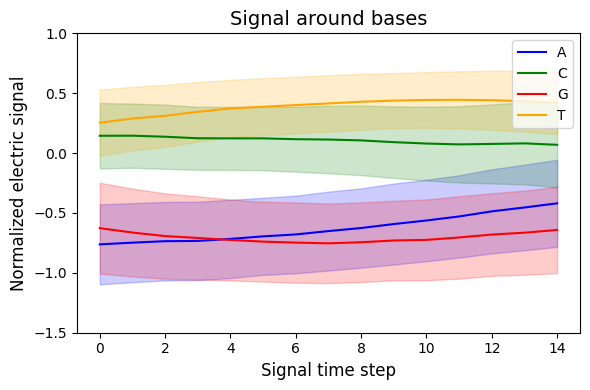

In [56]:
# 图形绘制
fig, ax = plt.subplots(figsize=(6, 4))  # 单一坐标轴

base_list = ["A", "C", "G", "T"]
color_list = ['blue', 'green', 'red', 'orange']

for i in range(4):
    ax.plot(dict_mean[i + 1], label=base_list[i], c=color_list[i])  # 绘制均值曲线
    ax.fill_between(
        list(range(15)),
        dict_mean[i + 1] - dict_std[i + 1] / 2,
        dict_mean[i + 1] + dict_std[i + 1] / 2,
        color=color_list[i],
        alpha=0.2
    )  # 绘制标准差阴影部分

ax.set_ylim([-1.5, 1])  # 设置y轴范围
ax.set_title("Signal around bases", fontsize=14)
ax.set_xlabel("Signal time step", fontsize=12)  # X轴标签
ax.set_ylabel("Normalized electric signal", fontsize=12)  # Y轴标签
ax.legend(loc='upper right')  # 图例位置

plt.tight_layout()
os.chdir("/data1/YHC/QiTanBasecall")
plt.savefig("fig1-D", dpi=400, bbox_inches="tight")  # 保存图片
plt.show()

In [181]:
pwd

'/data1/YHC'

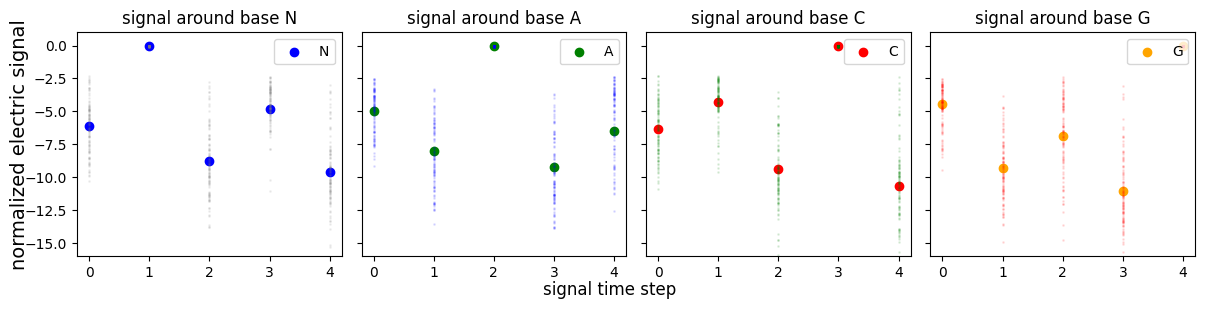

In [43]:
idxs = np.array([np.arange(15)] * 100, dtype=np.int16)

fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)

base_list = ["N", "A", "C", "G", "T"]
color_list = ["grey", 'blue', 'green', 'red', 'orange']

for i in range(4):
    input_mean = np.mean(input_dict[i + 1], axis=0)
    axes[i].scatter(np.arange(5), input_mean, label=base_list[i], c=color_list[i + 1])
    # axes[i].fill_between(list(range(15)), dict_mean[i + 1] - dict_std[i + 1] / 2, dict_mean[i + 1] + dict_std[i + 1] / 2, color=color_list[i], alpha=0.5)
    # axes[i].scatter(idxs, base_dict[i + 1][:len(idxs)], s=2, color=color_list[i], alpha=0.3)
    for j in range(100):
        axes[i].scatter(np.arange(5), input_dict[i + 1][j], c=color_list[i], alpha=0.1, s=1)
    axes[i].set_ylim([-16, 1])
    axes[i].set_title("signal around base {}".format(base_list[i]))
    axes[i].legend(loc='upper right')

fig.text(0.5, 0, 'signal time step', ha='center', fontsize=12)  # X轴标签
fig.text(0.0, 0.5, 'normalized electric signal', va='center', rotation='vertical', fontsize=14)  # Y轴标签

plt.tight_layout()
plt.show()

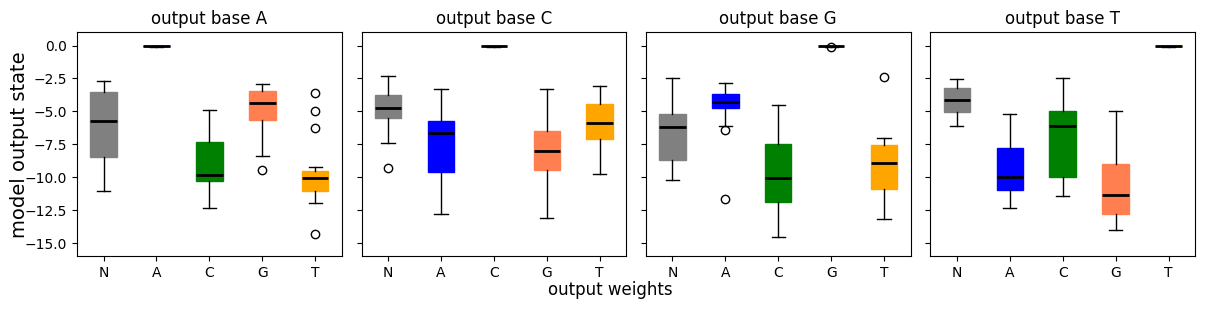

In [19]:
import matplotlib.pyplot as plt
import numpy as np


# 创建4个子图
# 创建4个子图
fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)


base_list = ["A", "C", "G", "T"]
color_list = ["lightgrey", 'lightblue', 'lightgreen', 'lightcoral', '#fffacd']  # 颜色列表
color_list = ["grey", 'blue', 'green', 'coral', 'orange']  # 颜色列表
x_labels = ["N", "A", "C", "G", "T"]  # 自定义x轴标签

for i in range(4):
    # 绘制箱线图，注意input_dict[i+1]每列对应一个时间步的数据
    box = axes[i].boxplot(input_dict[i + 1][:20], patch_artist=True, 
                           medianprops=dict(color="black", linewidth=2))
    
    # 手动为每个时间步设置颜色
    for j in range(5):  # 5个时间步
        plt.setp(box['boxes'][j], facecolor=color_list[j], edgecolor=color_list[j])

    # 设置自定义的x轴标签
    axes[i].set_xticks(np.arange(1, 6))  # 设置刻度位置（1到5）
    axes[i].set_xticklabels(x_labels)  # 设置刻度标签

    axes[i].set_ylim([-16, 1])
    axes[i].set_title("output base {}".format(base_list[i]))

# 设置统一的X轴和Y轴标签
fig.text(0.5, 0, 'output weights', ha='center', fontsize=12)  # X轴标签
fig.text(0.0, 0.5, 'model output state', va='center', rotation='vertical', fontsize=14)  # Y轴标签

# 调整子图布局
plt.tight_layout()
plt.savefig("fig1_2.png", dpi=400, bbox_inches="tight")
plt.show()

In [22]:
from models.model import BiLSTM_attn
from dataloader import Dataset_npy

In [24]:
model = BiLSTM_attn(kmer=21,
                    hidden_size=256,
                    embed_size=[16, 4],
                    dropout_rate=0.3,
                    num_layer1=2,
                    num_layer2=3,
                    num_classes=2)
model.load_state_dict(torch.load("/data1/YHC/Mod_save/lstm_attn_b21_s15_epoch16_accuracy:0.9630.pt"))
model = model.cuda()

In [25]:
dataset = Dataset_npy("/data1/YHC/QiTan_data/Mod/test/test.npy")

In [27]:
arr =  np.load("/data1/YHC/QiTan_data/Mod/test/test.npy")

In [28]:
pos = arr[np.argwhere(arr[:, -1]==1),:]
neg = arr[np.argwhere(arr[:, -1]==0),:]

In [29]:
pos_sig = pos[:, :, 21:-1 ].reshape(-1, 21,19)[:, 10, 4:]
neg_sig = neg[:, :, 21:-1 ].reshape(-1, 21,19)[:, 10, 4:]
pos_st = pos[:, :, 21:-1 ].reshape(-1, 21,19)[:, 10, :4]
neg_st = neg[:, :, 21:-1 ].reshape(-1, 21,19)[:, 10, :4]

In [30]:
pos_sig_mean = np.mean(pos_sig, axis=0)
pos_sig_std = np.std(pos_sig, axis=0)
neg_sig_mean = np.mean(neg_sig, axis=0)
neg_sig_std = np.std(neg_sig, axis=0)

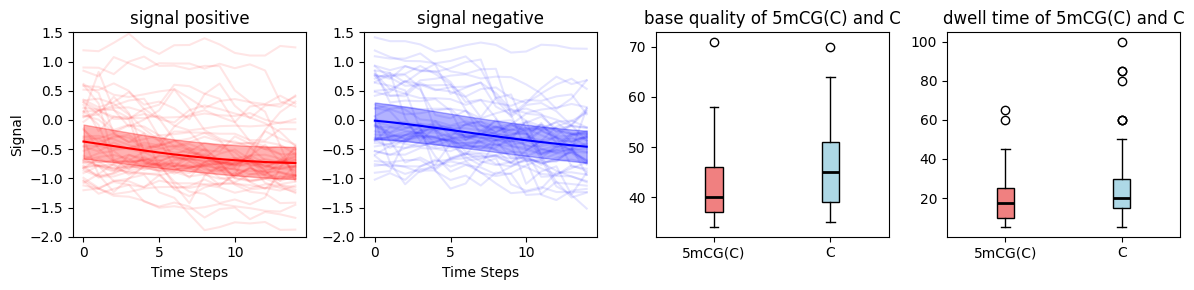

In [35]:
# 创建两个子图
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

# 第一个子图绘制pos数据
axes[0].plot(pos_sig_mean, c='red')
axes[0].fill_between(np.arange(15), pos_sig_mean - pos_sig_std / 2, pos_sig_mean + pos_sig_std / 2, alpha=0.3, color='red')
for j in range(50):
    axes[0].plot(pos_sig[j], c='red', alpha=0.1)

axes[0].set_title("signal positive")
axes[0].set_xlabel("Time Steps")
axes[0].set_ylabel("Signal")
axes[0].set_ylim(-2, 1.5)

# 第二个子图绘制neg数据
axes[1].plot(neg_sig_mean, c='blue')
axes[1].fill_between(np.arange(15), neg_sig_mean - neg_sig_std / 2, neg_sig_mean + neg_sig_std / 2, alpha=0.3, color='blue')
for j in range(50):
    axes[1].plot(neg_sig[j], c='blue', alpha=0.1)

axes[1].set_title("signal negative")
axes[1].set_xlabel("Time Steps")
axes[1].set_ylim(-2, 1.5)


box = axes[2].boxplot(np.concatenate((pos_st[:100, 3].reshape(-1, 1), neg_st[:100, 3].reshape(-1, 1)), axis=1)*12, 
                      patch_artist=True, 
                      medianprops=dict(color='black', linewidth=2))
plt.setp(box['boxes'][0], facecolor='lightcoral', edgecolor='black') 
plt.setp(box['boxes'][1], facecolor='lightblue', edgecolor='black') 
axes[2].set_xticks(np.arange(1, 3))  # 设置刻度位置（1到5）
axes[2].set_xticklabels(["5mCG(C)", "C"])  # 设置刻度标签
axes[2].set_title("base quality of 5mCG(C) and C")

box = axes[3].boxplot(np.concatenate((pos_st[:100, 2].reshape(-1, 1), neg_st[:100, 2].reshape(-1, 1)), axis=1), 
                      patch_artist=True, 
                    medianprops=dict(color='black', linewidth=2))
plt.setp(box['boxes'][0], facecolor='lightcoral', edgecolor='black') 
plt.setp(box['boxes'][1], facecolor='lightblue', edgecolor='black') 
axes[3].set_xticks(np.arange(1, 3))  # 设置刻度位置（1到5）
axes[3].set_xticklabels(["5mCG(C)", "C"])  # 设置刻度标签
axes[3].set_title("dwell time of 5mCG(C) and C")

# 调整子图布局
plt.tight_layout()
plt.savefig("fig1_3.png", dpi=400, bbox_inches="tight")

plt.show()